In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import GaussianNB, CategoricalNB

In [2]:
!pip install scikit-plot

In [3]:
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
)
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall

In [4]:
# importing dataset
from google.colab import files
uploaded = files.upload()

Saving train.csv to train.csv


In [5]:
from google.colab import files
uploaded1 = files.upload()

Saving test.csv to test.csv


In [30]:
import io
df_train = pd.read_csv(io.BytesIO(uploaded['train.csv']))

In [31]:
import io
df_test = pd.read_csv(io.BytesIO(uploaded1['test.csv']))

In [ ]:
df_train


In [ ]:
df_test

## Data preparation

In [32]:
#Changing udm to duration_ms and features_duration_ms from ms to min
df_train['duration_ms'] *= 1/6e4
df_test['duration_ms'] *= 1/6e4

In [33]:
#Setting trainset popularity as a %
df_train['popularity'] /= 100
df_train.rename(columns = {'duration_ms':'duration_min'}, inplace = True)
df_train.rename(columns = {'popularity':'popularity_percent'}, inplace = True)
#Setting test popularity as a %
df_test['popularity'] /= 100
df_test.rename(columns = {'duration_ms':'duration_min'}, inplace = True)
df_test.rename(columns = {'popularity':'popularity_percent'}, inplace = True)

In [34]:
df_train.isnull().sum()

name                         0
duration_min                 0
explicit                     0
popularity_percent           0
artists                      0
album_name                   0
danceability                 0
energy                       0
key                          0
loudness                     0
mode                      4450
speechiness                  0
acousticness                 0
instrumentalness             0
liveness                     0
valence                      0
tempo                        0
features_duration_ms         0
time_signature            2062
n_beats                      0
n_bars                       0
popularity_confidence    12783
processing                   0
genre                        0
dtype: int64

In [35]:
df_test.isnull().sum()

name                        0
duration_min                0
explicit                    0
popularity_percent          0
artists                     0
album_name                  0
danceability                0
energy                      0
key                         0
loudness                    0
mode                     1461
speechiness                 0
acousticness                0
instrumentalness            0
liveness                    0
valence                     0
tempo                       0
features_duration_ms        0
time_signature            725
n_beats                     0
n_bars                      0
popularity_confidence    4279
processing                  0
genre                       0
dtype: int64

In [36]:
#Dealing with mode attribute missing values train set
#Computing p0 and p1 and filling missing values of mode attribute by sampling
#df['mode'].value_counts().plot(kind='bar', title='mode')
p0=df_train['mode'].value_counts()[0]/(len(df_train)-df_train['mode'].isnull().sum())
p1=df_train['mode'].value_counts()[1]/(len(df_train)-df_train['mode'].isnull().sum())
#print(f'p0={p0} , p1={p1}')
list_of_nan_indexes=df_train[df_train['mode'].isnull()].index.tolist()
for i in list_of_nan_indexes:
    #df.loc[i,'mode']
    #df.loc[['viper', 'sidewinder'], ['shield']] = 50
    if np.random.random() < p1:
        df_train.loc[i,'mode'] = 1.0
    else:
        df_train.loc[i,'mode'] = 0.0

#Dealing with mode attribute missing values test set
#Computing p0 and p1 and filling missing values of mode attribute by sampling
#df['mode'].value_counts().plot(kind='bar', title='mode')
p0=df_test['mode'].value_counts()[0]/(len(df_test)-df_test['mode'].isnull().sum())
p1=df_test['mode'].value_counts()[1]/(len(df_test)-df_test['mode'].isnull().sum())
#print(f'p0={p0} , p1={p1}')
list_of_nan_indexes=df_test[df_test['mode'].isnull()].index.tolist()
for i in list_of_nan_indexes:
    #df.loc[i,'mode']
    #df.loc[['viper', 'sidewinder'], ['shield']] = 50
    if np.random.random() < p1:
        df_test.loc[i,'mode'] = 1.0
    else:
        df_test.loc[i,'mode'] = 0.0

In [37]:
df_train.dtypes

name                      object
duration_min             float64
explicit                    bool
popularity_percent       float64
artists                   object
album_name                object
danceability             float64
energy                   float64
key                        int64
loudness                 float64
mode                     float64
speechiness              float64
acousticness             float64
instrumentalness         float64
liveness                 float64
valence                  float64
tempo                    float64
features_duration_ms       int64
time_signature           float64
n_beats                  float64
n_bars                   float64
popularity_confidence    float64
processing               float64
genre                     object
dtype: object

In [38]:
#column2drop = ['features_duration_ms', 'popularity_confidence', 'processing', 'name','album_name'] #cols that gives max complexity
#df_train.drop(column2drop, axis=1, inplace=True)
#df_test.drop(column2drop, axis=1, inplace=True)

In [39]:
df_train.dtypes

name                      object
duration_min             float64
explicit                    bool
popularity_percent       float64
artists                   object
album_name                object
danceability             float64
energy                   float64
key                        int64
loudness                 float64
mode                     float64
speechiness              float64
acousticness             float64
instrumentalness         float64
liveness                 float64
valence                  float64
tempo                    float64
features_duration_ms       int64
time_signature           float64
n_beats                  float64
n_bars                   float64
popularity_confidence    float64
processing               float64
genre                     object
dtype: object

In [40]:
#Dealing with time_signature attribute missing values - train
#Computing the array containing the probabilities of every outcome for time_signature
outcomes_of_time_signature = len(df_train['time_signature'].value_counts())
p_array=np.array(df_train['time_signature'].value_counts().sort_index(ascending=True)/(len(df_train)-df_train['time_signature'].isnull().sum()))
#creating a dictionary containing the correspondance between value and sorted index
dict_ts = {0: 0.0, 1: 1.0, 2: 3.0, 3 : 4.0, 4 : 5.0}
list_of_nan_indexes_ts=df_train[df_train['time_signature'].isnull()].index.tolist()
from scipy.stats import multinomial
#please forgive the dunb programming here, no real deal of time, only ~3000 points to be evaluated
for i in list_of_nan_indexes_ts:
    tmp = multinomial.rvs(1, p_array, size=1, random_state=None)
    array_tmp=np.where(tmp[0][:]==1)
    index=array_tmp[0][0] #implement a dict for the substitution
    df_train.loc[i,'time_signature'] = dict_ts[index]

#Dealing with time_signature attribute missing values - test
#Computing the array containing the probabilities of every outcome for time_signature
outcomes_of_time_signature = len(df_test['time_signature'].value_counts())
p_array=np.array(df_test['time_signature'].value_counts().sort_index(ascending=True)/(len(df_test)-df_test['time_signature'].isnull().sum()))
#creating a dictionary containing the correspondance between value and sorted index
dict_ts = {0: 0.0, 1: 1.0, 2: 3.0, 3 : 4.0, 4 : 5.0}
list_of_nan_indexes_ts=df_test[df_test['time_signature'].isnull()].index.tolist()
from scipy.stats import multinomial
#please forgive the dunb programming here, no real deal of time, only ~3000 points to be evaluated
for i in list_of_nan_indexes_ts:
    tmp = multinomial.rvs(1, p_array, size=1, random_state=None)
    array_tmp=np.where(tmp[0][:]==1)
    index=array_tmp[0][0] #implement a dict for the substitution
    df_test.loc[i,'time_signature'] = dict_ts[index]

In [41]:
df_train.isnull().sum()

name                         0
duration_min                 0
explicit                     0
popularity_percent           0
artists                      0
album_name                   0
danceability                 0
energy                       0
key                          0
loudness                     0
mode                         0
speechiness                  0
acousticness                 0
instrumentalness             0
liveness                     0
valence                      0
tempo                        0
features_duration_ms         0
time_signature               0
n_beats                      0
n_bars                       0
popularity_confidence    12783
processing                   0
genre                        0
dtype: int64

In [42]:
df_test.isnull().sum()

name                        0
duration_min                0
explicit                    0
popularity_percent          0
artists                     0
album_name                  0
danceability                0
energy                      0
key                         0
loudness                    0
mode                        0
speechiness                 0
acousticness                0
instrumentalness            0
liveness                    0
valence                     0
tempo                       0
features_duration_ms        0
time_signature              0
n_beats                     0
n_bars                      0
popularity_confidence    4279
processing                  0
genre                       0
dtype: int64

In [43]:
#cols that gives max complexity or that are highly correlated
column2drop = ['features_duration_ms', 'popularity_confidence', 'processing', 'name', 'artists','album_name', 'n_bars', 'n_beats']
df_train.drop(column2drop, axis=1, inplace=True)
df_test.drop(column2drop, axis=1, inplace=True)

In [44]:
#Creating genre map I -> mapping every genre into an int value in order to have correlation values.
genre_map={"j-dance":0,"iranian":1,"brazil":2,"chicago-house":3,"forro":4,"idm":5,"indian":6,"study":7,"disney":8,"afrobeat":9,"mandopop":10,"techno":11,"sleep":12,"spanish":13,"j-idol":14,"industrial":15,"happy":16,"bluegrass":17,"black-metal":18,"breakbeat":19}

## First `genre` map - all genra in a different category

In [56]:
from sklearn.preprocessing import LabelEncoder

In [57]:
df_train = pd.get_dummies(df_train, columns=['key', 'time_signature'], dtype=int)
df_test = pd.get_dummies(df_test, columns=['key', 'time_signature'], dtype=int)

In [58]:
# label encoding explicit feature
le = LabelEncoder()
df_train['explicit'] = le.fit_transform(df_train['explicit'])
df_test['explicit'] = le.fit_transform(df_test['explicit'])

In [59]:
#Saving a variable containing all non-classification attributes
attributes = [col for col in df_train.columns if col != 'genre']

In [60]:
df_train.replace({'genre':genre_map}, inplace=True)
df_test.replace({'genre':genre_map}, inplace=True)

In [61]:
y_train = df_train['genre']
y_test = df_test['genre']

In [62]:
X_train = df_train[attributes].values
X_test = df_test[attributes].values

In [63]:
from sklearn.model_selection import train_test_split

In [64]:
random_state = 0

In [65]:
clf = GaussianNB()

In [66]:
%%time
clf.fit(X_train, y_train)

CPU times: user 11.1 ms, sys: 724 µs, total: 11.8 ms
Wall time: 13.8 ms


GaussianNB()

In [67]:
y_pred = clf.predict(X_test)
y_pred

array([3, 0, 4, ..., 3, 5, 0])

In [68]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.66      0.45      0.54      1500
           1       0.16      0.56      0.24       250
           2       0.47      0.16      0.24      1250
           3       0.39      0.36      0.38       750
           4       0.17      0.72      0.27       250
           5       0.54      0.60      0.57       250
           6       0.45      0.42      0.43       250
           7       0.55      0.42      0.47       500

    accuracy                           0.39      5000
   macro avg       0.42      0.46      0.39      5000
weighted avg       0.50      0.39      0.40      5000



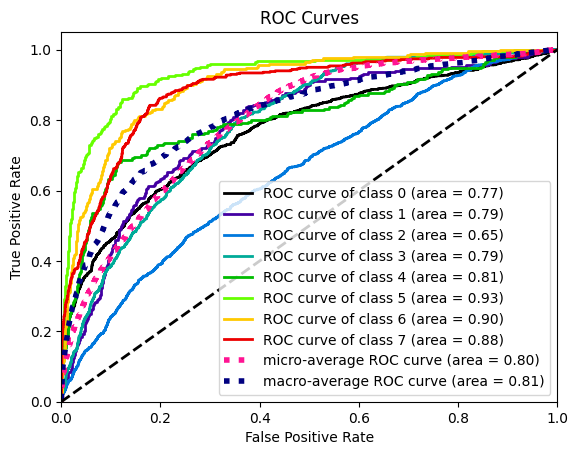

0.8146327108835815


In [69]:
plot_roc(y_test, clf.predict_proba(X_test))
plt.show()
print(roc_auc_score(y_test, clf.predict_proba(X_test), multi_class="ovr", average="macro"))

# Decision tree - II map

In [45]:
#Creating genre map II -> mapping in macro-categories as described above
macrogenre_map={"j-dance":2,"iranian":6,"brazil":3,"chicago-house":0,"forro":3,"idm":0,"indian":1,"study":7,"disney":2,"afrobeat":0,"mandopop":2,"techno":0,"sleep":7,"spanish":3,"j-idol":2,"industrial":0,"happy":2,"bluegrass":4,"black-metal":5,"breakbeat":0}


In [46]:
df_train.replace({'genre':macrogenre_map}, inplace=True)

In [47]:
df_test.replace({'genre':macrogenre_map}, inplace=True)

In [48]:
df_train['genre'].unique()

array([2, 6, 5, 4, 0, 3, 7, 1])

In [49]:
y_train = df_train['genre']
y_test = df_test['genre']

In [50]:
#Saving a variable containing all non-classification attributes
attributes = [col for col in df_train.columns if col != 'genre']

In [51]:
X_train = df_train[attributes].values
X_test = df_test[attributes].values

In [52]:
clf.fit(X_train, y_train)

GaussianNB()

In [53]:
y_pred = clf.predict(X_test)
y_pred

array([3, 0, 3, ..., 0, 5, 0])

In [54]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.69      0.56      0.62      1500
           1       0.25      0.27      0.26       250
           2       0.47      0.20      0.28      1250
           3       0.38      0.65      0.48       750
           4       0.29      0.65      0.40       250
           5       0.47      0.70      0.56       250
           6       0.50      0.40      0.44       250
           7       0.53      0.59      0.56       500

    accuracy                           0.48      5000
   macro avg       0.45      0.50      0.45      5000
weighted avg       0.51      0.48      0.47      5000



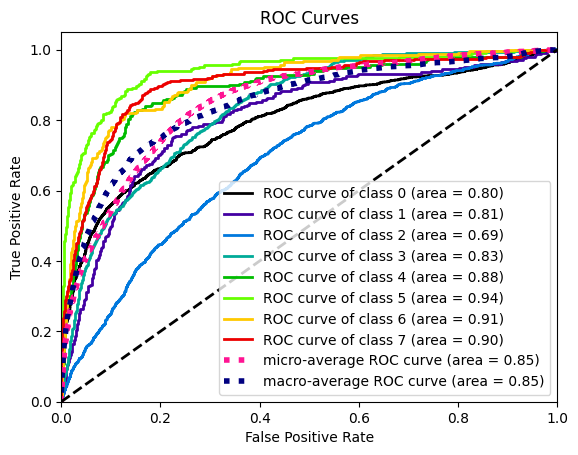

0.846286935890707


In [55]:
plot_roc(y_test, clf.predict_proba(X_test))
plt.show()
print(roc_auc_score(y_test, clf.predict_proba(X_test), multi_class="ovr", average="macro"))